In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yasserh/walmart-dataset")

print("Path to dataset files:", path)

100%|██████████| 122k/122k [00:00<00:00, 225kB/s]

Extracting model files...
Path to dataset files: C:\Users\OMEN\.cache\kagglehub\datasets\yasserh\walmart-dataset\versions\1


In [2]:
# Setup: libraries, style, configuration
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (12, 5)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

# Customized input path
INPUT_CSV = r"C:\Users\OMEN\.cache\kagglehub\datasets\yasserh\walmart-dataset\versions\1\Walmart.csv"
RANDOM_STATE = 42

assert os.path.exists(INPUT_CSV), f"File not found: {INPUT_CSV}"


In [3]:
# Load dataset and parse Date column
df = pd.read_csv(INPUT_CSV)

# Convert Date to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values('Date')

print("Shape:", df.shape)
print("Date range:", df['Date'].min(), "to", df['Date'].max())
display(df.head(10))
display(df.info())


Shape: (6435, 8)
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1287,10,2010-02-05,2193048.75,0,54.34,2.962,126.442065,9.765
5148,37,2010-02-05,536006.73,0,45.97,2.572,209.852966,8.554
2288,17,2010-02-05,789036.02,0,23.11,2.666,126.442065,6.548
4147,30,2010-02-05,465108.52,0,39.05,2.572,210.752605,8.324
3432,25,2010-02-05,677231.63,0,21.10,2.784,204.247194,8.187
3003,22,2010-02-05,1033017.37,0,24.36,2.788,135.352461,8.283
3146,23,2010-02-05,1364721.58,0,15.25,2.788,131.527903,5.892
3289,24,2010-02-05,1388725.63,0,22.43,2.954,131.527903,8.326
2574,19,2010-02-05,1507637.17,0,20.96,2.954,131.527903,8.350


<class 'pandas.core.frame.DataFrame'>
Index: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 452.5 KB


None

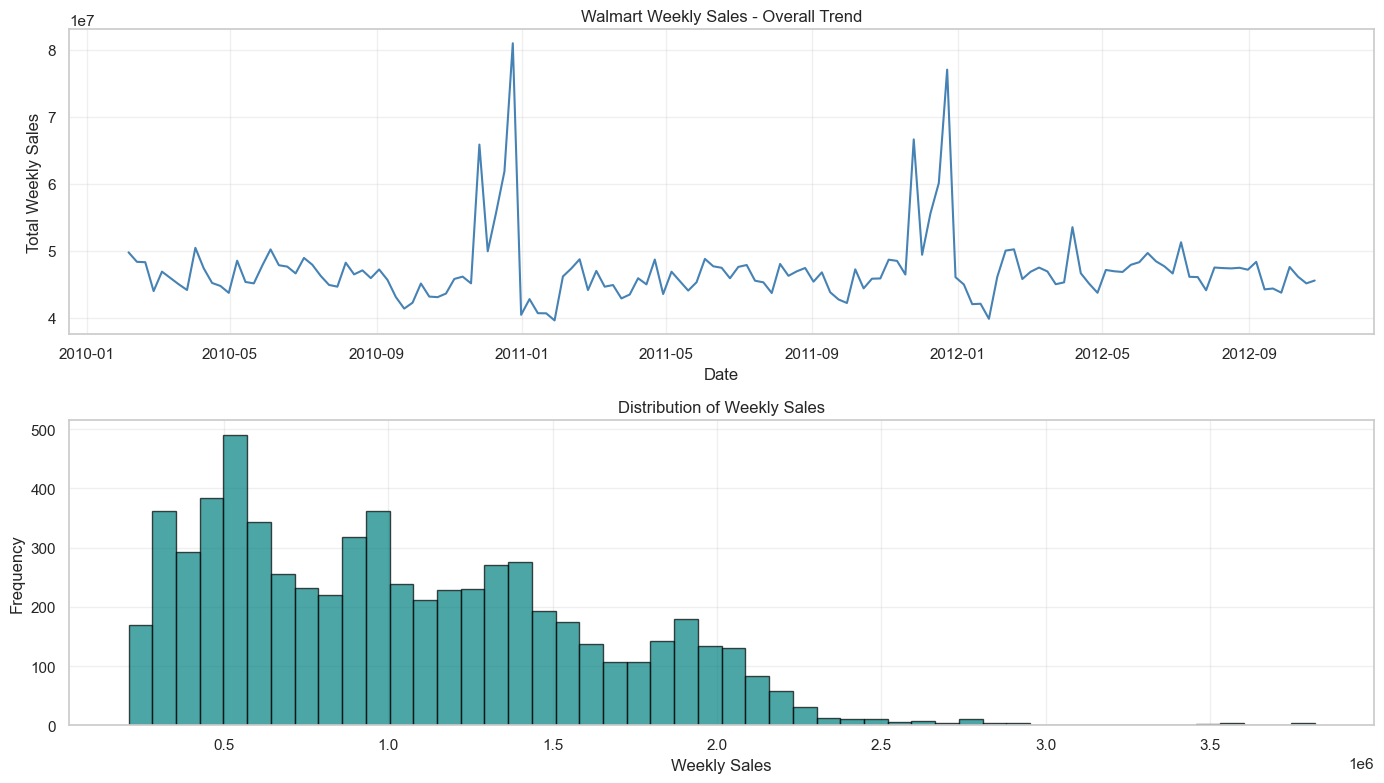

In [4]:
# Aggregate weekly sales across all stores for overall trend
sales_by_date = df.groupby('Date')['Weekly_Sales'].sum().reset_index()

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Overall sales trend
axes[0].plot(sales_by_date['Date'], sales_by_date['Weekly_Sales'], color='steelblue', linewidth=1.5)
axes[0].set_title("Walmart Weekly Sales - Overall Trend")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Total Weekly Sales")
axes[0].grid(alpha=0.3)

# Distribution
axes[1].hist(df['Weekly_Sales'], bins=50, color='teal', edgecolor='black', alpha=0.7)
axes[1].set_title("Distribution of Weekly Sales")
axes[1].set_xlabel("Weekly Sales")
axes[1].set_ylabel("Frequency")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [5]:
# Create lag features (previous 3 and 6 weeks sales)
# Sort by Store and Date to ensure proper lag creation
df_fe = df.copy()
df_fe = df_fe.sort_values(['Store', 'Date'])

# Create lag features per store
df_fe['Sales_Lag_1'] = df_fe.groupby('Store')['Weekly_Sales'].shift(1)
df_fe['Sales_Lag_2'] = df_fe.groupby('Store')['Weekly_Sales'].shift(2)
df_fe['Sales_Lag_3'] = df_fe.groupby('Store')['Weekly_Sales'].shift(3)
df_fe['Sales_Lag_6'] = df_fe.groupby('Store')['Weekly_Sales'].shift(6)

# Create rolling mean features
df_fe['Sales_Roll_Mean_3'] = df_fe.groupby('Store')['Weekly_Sales'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df_fe['Sales_Roll_Mean_6'] = df_fe.groupby('Store')['Weekly_Sales'].transform(lambda x: x.rolling(window=6, min_periods=1).mean())

# Extract time-based features
df_fe['Year'] = df_fe['Date'].dt.year
df_fe['Month'] = df_fe['Date'].dt.month
df_fe['Week'] = df_fe['Date'].dt.isocalendar().week
df_fe['DayOfYear'] = df_fe['Date'].dt.dayofyear

# Drop rows with NaN lag features (first weeks per store)
df_fe = df_fe.dropna()

print("After feature engineering shape:", df_fe.shape)
display(df_fe.head(10))


After feature engineering shape: (6165, 18)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Sales_Lag_1,Sales_Lag_2,Sales_Lag_3,Sales_Lag_6,Sales_Roll_Mean_3,Sales_Roll_Mean_6,Year,Month,Week,DayOfYear
6,1,2010-03-19,1472515.79,0,54.58,2.720,211.215635,8.106,1439541.59,1554806.68,1409727.59,1643690.90,1.488955e+06,1.521753e+06,2010,3,11,78
7,1,2010-03-26,1404429.92,0,51.45,2.732,211.018042,8.106,1472515.79,1439541.59,1554806.68,1641957.44,1.438829e+06,1.482165e+06,2010,3,12,85
8,1,2010-04-02,1594968.28,0,62.27,2.719,210.820450,7.808,1404429.92,1472515.79,1439541.59,1611968.17,1.490638e+06,1.479332e+06,2010,4,13,92
9,1,2010-04-09,1545418.53,0,65.86,2.770,210.622857,7.808,1594968.28,1404429.92,1472515.79,1409727.59,1.514939e+06,1.501947e+06,2010,4,14,99
10,1,2010-04-16,1466058.28,0,66.32,2.808,210.488700,7.808,1545418.53,1594968.28,1404429.92,1554806.68,1.535482e+06,1.487155e+06,2010,4,15,106
11,1,2010-04-23,1391256.12,0,64.84,2.795,210.439123,7.808,1466058.28,1545418.53,1594968.28,1439541.59,1.467578e+06,1.479108e+06,2010,4,16,113
12,1,2010-04-30,1425100.71,0,67.41,2.780,210.389546,7.808,1391256.12,1466058.28,1545418.53,1472515.79,1.427472e+06,1.471205e+06,2010,4,17,120
13,1,2010-05-07,1603955.12,0,72.55,2.835,210.339968,7.808,1425100.71,1391256.12,1466058.28,1404429.92,1.473437e+06,1.504460e+06,2010,5,18,127
14,1,2010-05-14,1494251.50,0,74.78,2.854,210.337426,7.808,1603955.12,1425100.71,1391256.12,1594968.28,1.507769e+06,1.487673e+06,2010,5,19,134
15,1,2010-05-21,1399662.07,0,76.44,2.826,210.617093,7.808,1494251.50,1603955.12,1425100.71,1545418.53,1.499290e+06,1.463381e+06,2010,5,20,141


In [6]:
# Define features and target
feature_cols = ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
                'Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_3', 'Sales_Lag_6',
                'Sales_Roll_Mean_3', 'Sales_Roll_Mean_6',
                'Year', 'Month', 'Week', 'DayOfYear']

X = df_fe[feature_cols].copy()
y = df_fe['Weekly_Sales'].copy()

# Train/test split (time-based: use earlier data for training)
# Alternative: can use train_test_split with shuffle=False for time series
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)


Train shape: (4932, 16) | Test shape: (1233, 16)


In [7]:
# 1. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = math.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression:")
print(f"  MAE:  {mae_lr:,.2f}")
print(f"  RMSE: {rmse_lr:,.2f}")
print(f"  R²:   {r2_lr:.4f}\n")

# 2. Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = math.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest:")
print(f"  MAE:  {mae_rf:,.2f}")
print(f"  RMSE: {rmse_rf:,.2f}")
print(f"  R²:   {r2_rf:.4f}\n")

# 3. XGBoost
xgb = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=RANDOM_STATE, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = math.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost:")
print(f"  MAE:  {mae_xgb:,.2f}")
print(f"  RMSE: {rmse_xgb:,.2f}")
print(f"  R²:   {r2_xgb:.4f}")


Linear Regression:
  MAE:  0.00
  RMSE: 0.00
  R²:   1.0000

Random Forest:
  MAE:  20,180.43
  RMSE: 34,360.98
  R²:   0.9923

XGBoost:
  MAE:  19,795.95
  RMSE: 28,374.46
  R²:   0.9948


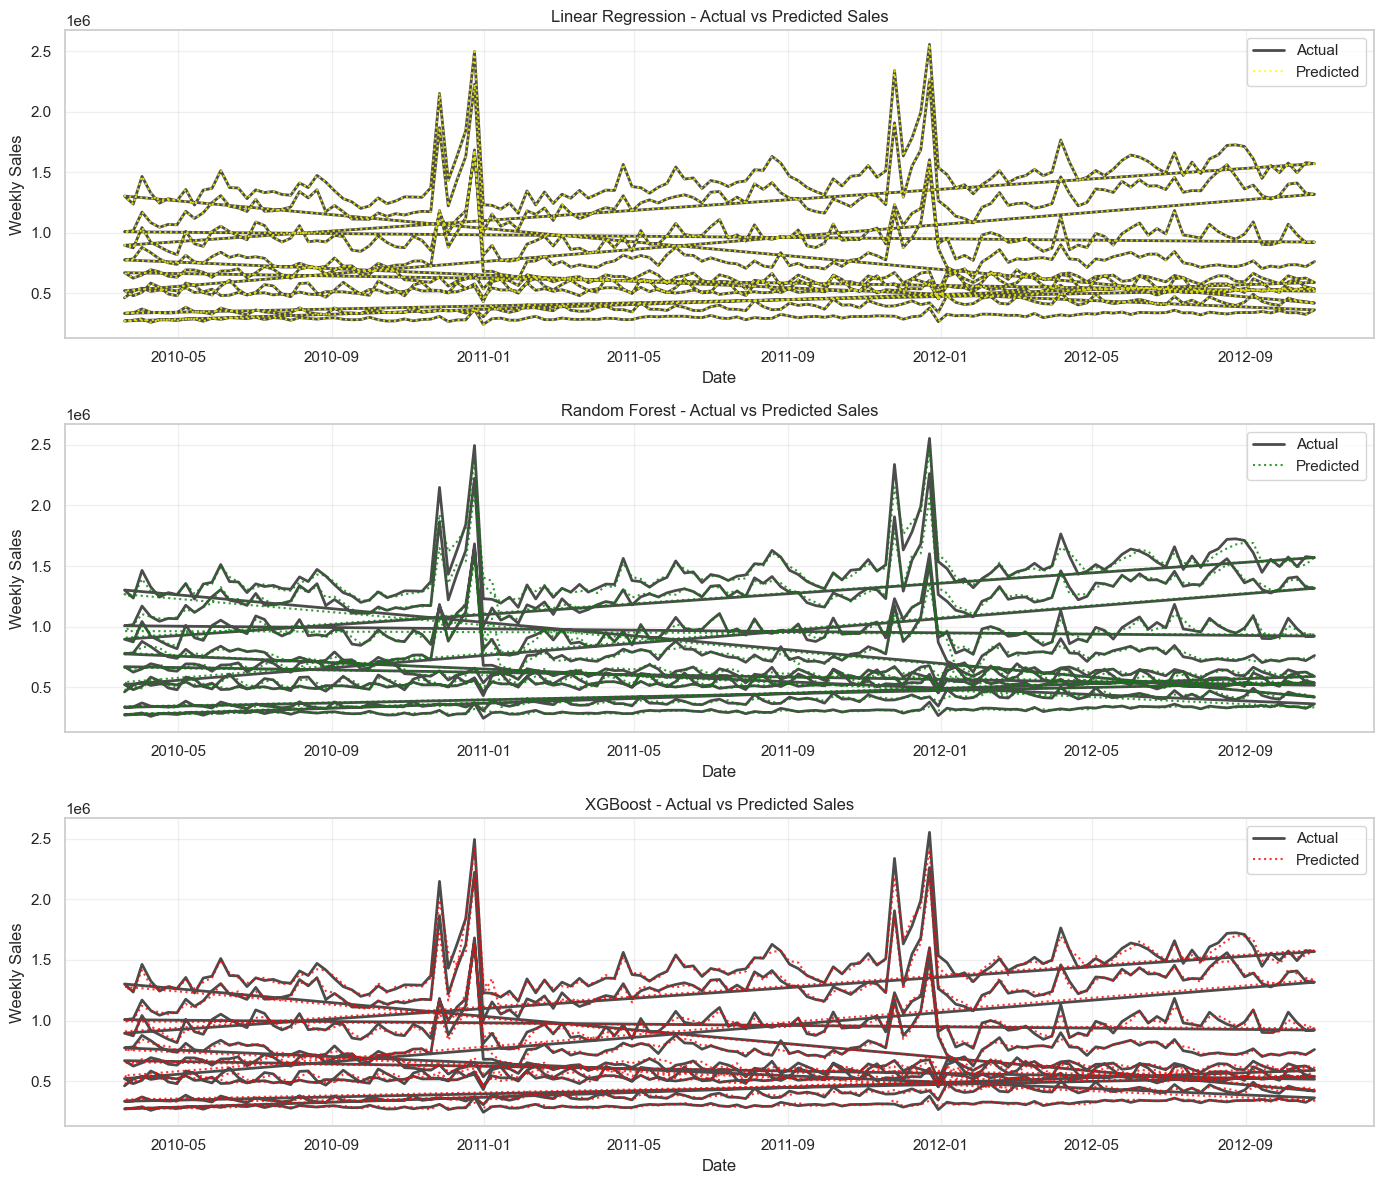

In [11]:
# Plot actual vs predicted for each model
test_dates = df_fe.iloc[split_idx:]['Date'].values

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

models = [
    ("Linear Regression", y_pred_lr, 'yellow'),
    ("Random Forest", y_pred_rf, 'green'),
    ("XGBoost", y_pred_xgb, 'red')
]

for idx, (name, preds, color) in enumerate(models):
    axes[idx].plot(test_dates, y_test.values, label='Actual', color='black', linewidth=2, alpha=0.7)
    axes[idx].plot(test_dates, preds, label='Predicted', color=color, linewidth=1.5, alpha=0.8, linestyle = ':')
    axes[idx].set_title(f"{name} - Actual vs Predicted Sales")
    axes[idx].set_xlabel("Date")
    axes[idx].set_ylabel("Weekly Sales")
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()


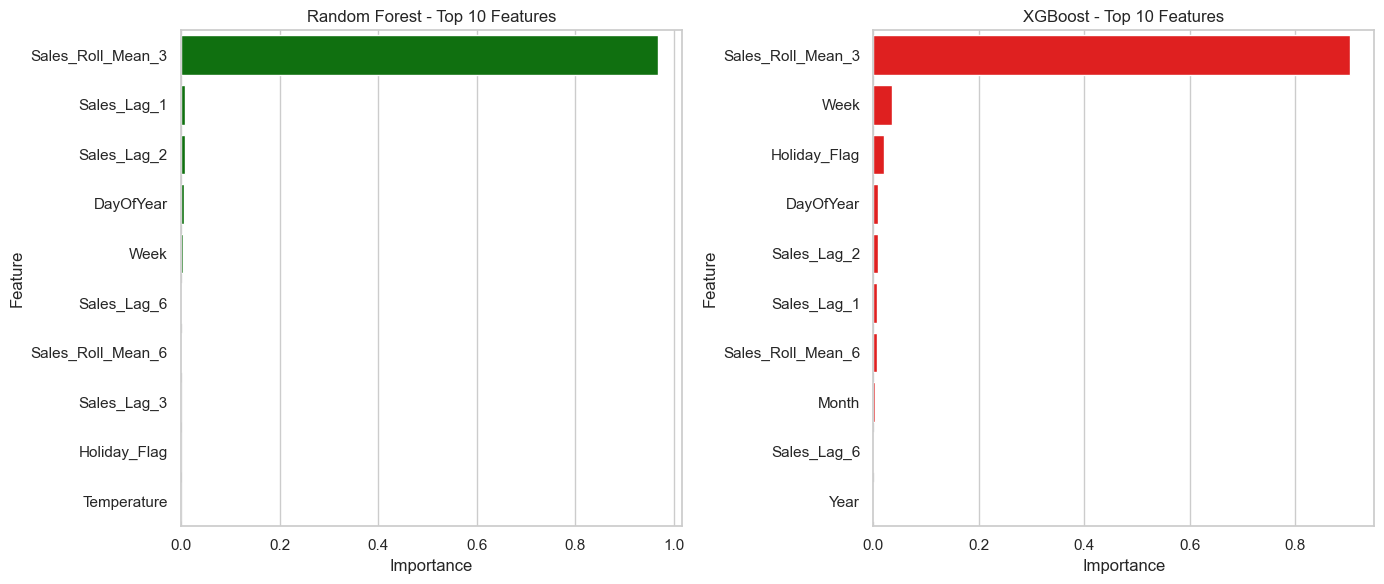

In [12]:
# Feature importance from Random Forest
rf_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Feature importance from XGBoost
xgb_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb.feature_importances_
}).sort_values('Importance', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(data=rf_importance.head(10), x='Importance', y='Feature', ax=axes[0], color='green')
axes[0].set_title("Random Forest - Top 10 Features")

sns.barplot(data=xgb_importance.head(10), x='Importance', y='Feature', ax=axes[1], color='red')
axes[1].set_title("XGBoost - Top 10 Features")

plt.tight_layout()
plt.show()



Model Comparison:


,Model,MAE,RMSE,R²
0,Linear Regression,4.132673e-09,5.210903e-09,1.000000
1,Random Forest,2.018043e+04,3.436098e+04,0.992319
2,XGBoost,1.979595e+04,2.837446e+04,0.994763


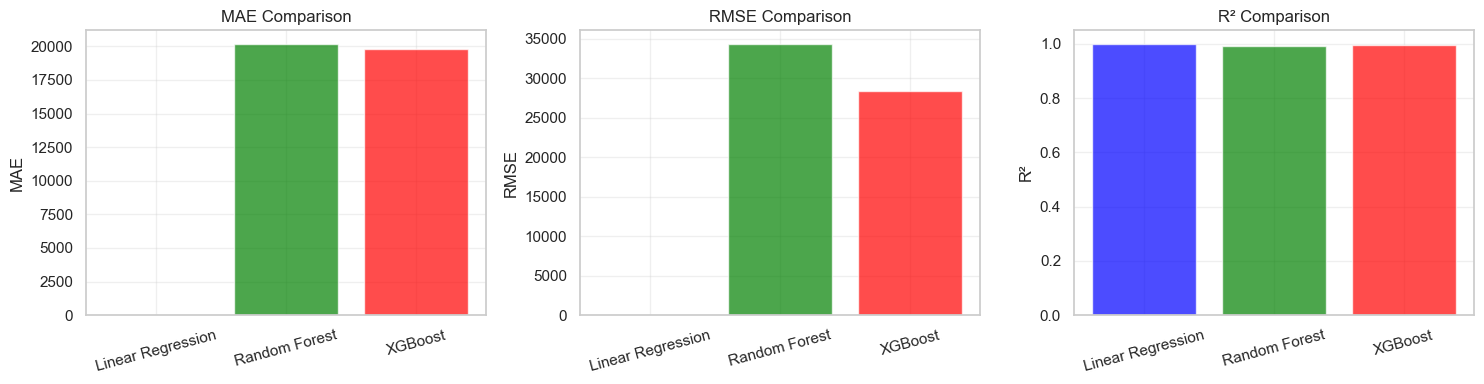

In [13]:
# Summary comparison
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'MAE': [mae_lr, mae_rf, mae_xgb],
    'RMSE': [rmse_lr, rmse_rf, rmse_xgb],
    'R²': [r2_lr, r2_rf, r2_xgb]
})

print("\nModel Comparison:")
display(comparison)

# Bar plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = ['MAE', 'RMSE', 'R²']
for idx, metric in enumerate(metrics):
    axes[idx].bar(comparison['Model'], comparison[metric], color=['blue', 'green', 'red'], alpha=0.7)
    axes[idx].set_title(f"{metric} Comparison")
    axes[idx].set_ylabel(metric)
    axes[idx].tick_params(axis='x', rotation=15)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()
